This notebook allows for quick reporting of median parameters with uncertainties and calculation of resulting yield parameters to input into models.

In [30]:
import pandas as pd
import numpy as np
import surp
import vice

In [31]:
from mc_plot_utils import MCMCResult

In [32]:
def get_params(filename):
    df = pd.read_csv("../models/mcmc_models_2d/" + filename + "/mcmc_summary.csv")

    result = MCMCResult.from_file("../models/mcmc_models_2d/" + filename +  "/")


    for label in result.all_labels:
        if label not in df.parameters.values:
            print(label)
            df = pd.concat([df, 
                    pd.DataFrame({"parameters": label, "median": result.samples[label].median(), "err_low": 0, "err_high": 0
                                 }, index=[1])
                ], ignore_index=True)

    for (i, r) in df.iterrows():
        print(f'{r.parameters:8}\t{r["median"]:0.3f}\t-{r.err_low:0.3f}\t+{r.err_high:0.3f}')
        

    return df

In [33]:
def get_df_key(df, key):
    try:
        return df[df.parameters == key]["median"].iloc[0]
    except Exception as e:
        return np.nan

In [34]:
def to_log_slope(slope):
    return slope / surp.Z_SUN / surp.yield_models.zeta_to_slope(1)

In [35]:
def make_new_params(df, study="fruity"):
    y0_l = get_df_key(df, "y0_cc")
    slope = get_df_key(df, "zeta_cc")
    alpha = get_df_key(df, "alpha")

    y0 = (y0_l + slope)*1e-3
    zeta = 1e-3 * slope / surp.Z_SUN / surp.yield_models.zeta_to_slope(1)
    
    print(f"alpha_c_agb = {alpha:0.2f}" )
    print(f"y0_c_cc = {y0:0.2e}" )
    print(f"zeta_c_cc = {zeta:0.2e}", )
    
    f_agb = yagb_props[study]["y0"] * alpha / (yagb_props[study]["y0"] * alpha + y0)
    print(f"f = {f_agb:0.3f}" )


In [36]:
def make_f_agb(df, f_new, study="fruity"):
    y0_l = get_df_key(df, "y0_cc")
    slope = get_df_key(df, "zeta_cc")
    alpha = get_df_key(df, "alpha")
    y0 = (y0_l + slope) * 1e-3
    
    ya = yagb_props[study]["y0"]
    ytot = ya * alpha + y0
    
    f_agb = ya * alpha / ytot

    alpha_new = f_new * ytot / ya

    y0_new = ytot - alpha_new * ya
    f_new_new = ya * alpha_new / ytot

    print(f"y0 = {y0_new:0.3e}" )
    print(f"alpha = {alpha_new:0.3f}" )

    print(f"f = {f_new_new:0.3f}" )


In [37]:
df = pd.read_csv("yield_fits.tsv", sep=r"\s+", comment="#")
df

,model,y0,zeta0,zeta0_err,zeta1,zeta1_err
0,fruity,3.110,3.7,0.3,-3.5,0.3
1,aton,-0.009,1.0,1.9,-10.0,3.0
2,monash,2.960,2.3,0.5,-11.0,1.0
3,nugrid,9.250,8.1,1.9,-4.6,1.7
4,fruity_mf0.5,2.830,3.3,0.2,-1.8,0.2
5,fruity_mf0.7,3.600,4.2,0.3,-3.1,0.3
6,fruity_mf1.5,3.110,3.4,0.2,-3.0,0.2


In [38]:
vice.yields.agb.settings["c"] = surp.agb_interpolator.interpolator("c", mass_factor=0.7)
surp.yields.calc_y(surp.Z_SUN, kind="agb") * 1e3

0.3604729682654721

In [39]:
yagb_props = {}

for _, row in df.iterrows():
    yagb_props[row.model] = {
        "y0": row.y0 * 1e-4,
        "y_a": row.zeta0 * 0e-4,
        "zeta_a": row.zeta1 * 0e-4,
    }

yagb_props["analytic"] = {
    "y0": 1e-3,
    "y_a": 1e-3,
    "zeta_a": 1e-3
}

yagb_props

{'fruity': {'y0': 0.000311, 'y_a': 0.0, 'zeta_a': -0.0},
 'aton': {'y0': -9e-07, 'y_a': 0.0, 'zeta_a': -0.0},
 'monash': {'y0': 0.000296, 'y_a': 0.0, 'zeta_a': -0.0},
 'nugrid': {'y0': 0.000925, 'y_a': 0.0, 'zeta_a': -0.0},
 'fruity_mf0.5': {'y0': 0.000283, 'y_a': 0.0, 'zeta_a': -0.0},
 'fruity_mf0.7': {'y0': 0.00036, 'y_a': 0.0, 'zeta_a': -0.0},
 'fruity_mf1.5': {'y0': 0.000311, 'y_a': 0.0, 'zeta_a': -0.0},
 'analytic': {'y0': 0.001, 'y_a': 0.001, 'zeta_a': 0.001}}

# simple yields

## Making new model parameters

In [40]:
df = get_params("fiducial")

for f in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]: 
    make_f_agb(df, f_new=f, study="fruity")

    print()

y0_cc   	1.509	-0.019	+0.019
alpha   	1.556	-0.041	+0.041
zeta_cc 	0.719	-0.009	+0.010
y0 = 2.712e-03
alpha = 0.000
f = 0.000

y0 = 2.441e-03
alpha = 0.872
f = 0.100

y0 = 2.170e-03
alpha = 1.744
f = 0.200

y0 = 1.899e-03
alpha = 2.616
f = 0.300

y0 = 1.627e-03
alpha = 3.488
f = 0.400

y0 = 1.356e-03
alpha = 4.360
f = 0.500

y0 = 1.085e-03
alpha = 5.233
f = 0.600

y0 = 5.424e-04
alpha = 6.977
f = 0.800



In [41]:
df = get_params("fruity_fz0.3")
print()
make_new_params(df, "fruity")

alpha
y0_cc   	1.080	-0.008	+0.009
zeta_cc 	0.789	-0.010	+0.009
alpha   	2.570	-0.000	+0.000

alpha_c_agb = 2.57
y0_c_cc = 1.87e-03
zeta_c_cc = 1.82e-03
f = 0.300


In [42]:
df = get_params("fiducial_constrained")
0.919e-3 + 2.715 * yagb_props["fruity"]["y0"] + 0.902e-3

y0_cc
alpha   	2.970	-0.019	+0.019
zeta_cc 	0.941	-0.008	+0.008
y0_cc   	0.790	-0.000	+0.000


0.0026653650000000003

In [43]:
df = get_params("fiducial")
print()
make_new_params(df, "fruity")

y0_cc   	1.509	-0.019	+0.019
alpha   	1.556	-0.041	+0.041
zeta_cc 	0.719	-0.009	+0.010

alpha_c_agb = 1.56
y0_c_cc = 2.23e-03
zeta_c_cc = 1.66e-03
f = 0.178


In [44]:
df = get_params("fiducial_2")
print()
make_new_params(df, "fruity")

y0_cc   	1.509	-0.019	+0.019
alpha   	1.556	-0.041	+0.042
zeta_cc 	0.719	-0.009	+0.010

alpha_c_agb = 1.56
y0_c_cc = 2.23e-03
zeta_c_cc = 1.66e-03
f = 0.178


In [45]:
df = get_params("fiducial_sigma")
print()
make_new_params(df, "fruity")

y0_cc   	1.649	-0.038	+0.038
alpha   	1.619	-0.100	+0.101
zeta_cc 	0.543	-0.037	+0.036
sigma_int	0.021	-0.002	+0.002

alpha_c_agb = 1.62
y0_c_cc = 2.19e-03
zeta_c_cc = 1.25e-03
f = 0.187


In [46]:
df = get_params("fiducial_sigma0.05")
print()
make_new_params(df, "fruity")

y0_cc   	1.663	-0.072	+0.071
alpha   	1.677	-0.197	+0.194
zeta_cc 	0.505	-0.076	+0.077

alpha_c_agb = 1.68
y0_c_cc = 2.17e-03
zeta_c_cc = 1.16e-03
f = 0.194


In [47]:
df = get_params("fiducial_sigma0.02")
print()
make_new_params(df, "fruity")

y0_cc   	1.743	-0.039	+0.039
alpha   	1.544	-0.096	+0.097
zeta_cc 	0.433	-0.038	+0.039

alpha_c_agb = 1.54
y0_c_cc = 2.18e-03
zeta_c_cc = 9.97e-04
f = 0.181


In [48]:
df = get_params("fiducial_constrained")
print()
make_new_params(df, "fruity")

y0_cc
alpha   	2.970	-0.019	+0.019
zeta_cc 	0.941	-0.008	+0.008
y0_cc   	0.790	-0.000	+0.000

alpha_c_agb = 2.97
y0_c_cc = 1.73e-03
zeta_c_cc = 2.17e-03
f = 0.348


In [49]:
df = get_params("aton")
print()
make_new_params(df, "aton")

y0_cc   	1.489	-0.020	+0.020
alpha   	1.067	-0.029	+0.029
zeta_cc 	1.128	-0.017	+0.016

alpha_c_agb = 1.07
y0_c_cc = 2.62e-03
zeta_c_cc = 2.60e-03
f = -0.000


In [50]:
df = get_params("aton_constrained")
print()
make_new_params(df, "aton")

y0_cc   	0.898	-0.009	+0.009
alpha   	1.853	-0.019	+0.019
zeta_cc 	1.604	-0.009	+0.009

alpha_c_agb = 1.85
y0_c_cc = 2.50e-03
zeta_c_cc = 3.69e-03
f = -0.001


In [51]:
df = get_params("monash")
print()
make_new_params(df, "monash")

y0_cc   	1.284	-0.032	+0.031
alpha   	1.124	-0.038	+0.039
zeta_cc 	1.084	-0.018	+0.019

alpha_c_agb = 1.12
y0_c_cc = 2.37e-03
zeta_c_cc = 2.50e-03
f = 0.123


In [52]:
df = get_params("monash_constrained")
print()
make_new_params(df, "monash")

y0_cc
alpha   	1.713	-0.012	+0.011
zeta_cc 	1.362	-0.006	+0.006
y0_cc   	0.790	-0.000	+0.000

alpha_c_agb = 1.71
y0_c_cc = 2.15e-03
zeta_c_cc = 3.14e-03
f = 0.191


In [53]:
df = get_params("nugrid")
print()
make_new_params(df, "nugrid")

y0_cc   	1.780	-0.014	+0.013
alpha   	0.594	-0.018	+0.018
zeta_cc 	0.451	-0.010	+0.010

alpha_c_agb = 0.59
y0_c_cc = 2.23e-03
zeta_c_cc = 1.04e-03
f = 0.198


In [54]:
df = get_params("nugrid_constrained")
print()
make_new_params(df, "nugrid")

y0_cc
alpha   	1.635	-0.011	+0.011
zeta_cc 	0.491	-0.011	+0.011
y0_cc   	0.790	-0.000	+0.000

alpha_c_agb = 1.64
y0_c_cc = 1.28e-03
zeta_c_cc = 1.13e-03
f = 0.541


In [55]:
df = get_params("fruity_mf0.7")
print()
make_new_params(df, "fruity_mf0.7")

y0_cc   	1.871	-0.010	+0.010
alpha   	1.294	-0.029	+0.029
zeta_cc 	0.460	-0.010	+0.010

alpha_c_agb = 1.29
y0_c_cc = 2.33e-03
zeta_c_cc = 1.06e-03
f = 0.167


In [56]:
df = get_params("fruity_mf0.7_constrained")
print()
make_new_params(df, "fruity_mf0.7")

y0_cc
alpha   	3.048	-0.025	+0.026
zeta_cc 	0.978	-0.010	+0.010
y0_cc   	0.790	-0.000	+0.000

alpha_c_agb = 3.05
y0_c_cc = 1.77e-03
zeta_c_cc = 2.25e-03
f = 0.383


In [74]:
get_params("../mcmc_models_1d/fz_0.0");
print()
make_new_params(df, "fruity")

alpha
y0_cc   	2.379	-0.011	+0.011
zeta_cc 	0.412	-0.012	+0.012
alpha   	0.000	-0.000	+0.000

alpha_c_agb = 0.00
y0_c_cc = 2.78e-03
zeta_c_cc = 1.48e-03
f = 0.000


In [75]:
df = get_params("../mcmc_models_1d/fz_0.5");
print()
make_new_params(df, "fruity")

alpha
y0_cc   	0.000	-0.011	+0.012
zeta_cc 	1.211	-0.012	+0.012
alpha   	4.360	-0.000	+0.000

alpha_c_agb = 4.36
y0_c_cc = 1.21e-03
zeta_c_cc = 2.79e-03
f = 0.528


In [73]:
df = get_params("fruity_fz0.0")
print()
make_new_params(df, "fruity")

alpha
y0_cc   	2.138	-0.008	+0.008
zeta_cc 	0.642	-0.009	+0.009
alpha   	0.000	-0.000	+0.000

alpha_c_agb = 0.00
y0_c_cc = 2.78e-03
zeta_c_cc = 1.48e-03
f = 0.000


In [58]:
df = get_params("fruity_fz0.1")
print()
make_new_params(df, "fruity")

alpha
y0_cc   	1.797	-0.008	+0.008
zeta_cc 	0.679	-0.009	+0.009
alpha   	0.857	-0.000	+0.000

alpha_c_agb = 0.86
y0_c_cc = 2.48e-03
zeta_c_cc = 1.56e-03
f = 0.097


In [59]:
df = get_params("fruity_fz0.5")
print()
make_new_params(df, "fruity")

alpha
y0_cc   	0.294	-0.009	+0.009
zeta_cc 	0.943	-0.010	+0.010
alpha   	4.360	-0.000	+0.000

alpha_c_agb = 4.36
y0_c_cc = 1.24e-03
zeta_c_cc = 2.17e-03
f = 0.523


In [60]:
df = get_params("fruity_mf0.5_fixed")
print()
make_new_params(df, "fruity_mf0.5")

alpha
y0_cc   	2.060	-0.009	+0.009
zeta_cc 	0.145	-0.010	+0.010
alpha   	2.980	-0.000	+0.000

alpha_c_agb = 2.98
y0_c_cc = 2.21e-03
zeta_c_cc = 3.34e-04
f = 0.277


In [61]:
df = get_params("fruity_mf0.7_fixed")
print()
make_new_params(df, "fruity")

alpha
y0_cc   	1.655	-0.008	+0.008
zeta_cc 	0.316	-0.009	+0.009
alpha   	2.340	-0.000	+0.000

alpha_c_agb = 2.34
y0_c_cc = 1.97e-03
zeta_c_cc = 7.27e-04
f = 0.270


In [62]:
df = get_params("fruity_mf1.5_fixed")
print()
make_new_params(df, "fruity_mf1.5")

alpha
y0_cc   	1.010	-0.009	+0.009
zeta_cc 	0.847	-0.010	+0.010
alpha   	2.710	-0.000	+0.000

alpha_c_agb = 2.71
y0_c_cc = 1.86e-03
zeta_c_cc = 1.95e-03
f = 0.312


In [63]:
df = get_params("fruity_mf0.7")
print()
make_new_params(df, "fruity_mf0.7")

y0_cc   	1.871	-0.010	+0.010
alpha   	1.294	-0.029	+0.029
zeta_cc 	0.460	-0.010	+0.010

alpha_c_agb = 1.29
y0_c_cc = 2.33e-03
zeta_c_cc = 1.06e-03
f = 0.167


In [64]:
2.68 / 2

1.34

## Scalar comparisons

In [65]:
get_params("fiducial");

y0_cc   	1.509	-0.019	+0.019
alpha   	1.556	-0.041	+0.041
zeta_cc 	0.719	-0.009	+0.010


In [66]:
get_params("fiducial_0.5bins");

y0_cc   	1.443	-0.020	+0.020
alpha   	1.644	-0.045	+0.044
zeta_cc 	0.763	-0.010	+0.009


In [67]:
get_params("fiducial_1.5bins");

y0_cc   	1.586	-0.020	+0.020
alpha   	1.489	-0.041	+0.042
zeta_cc 	0.641	-0.010	+0.010


In [68]:
get_params("fiducial_sigma0.02");

y0_cc   	1.743	-0.039	+0.039
alpha   	1.544	-0.096	+0.097
zeta_cc 	0.433	-0.038	+0.039


In [112]:
get_params("fiducial_sigma");

y0_cc   	1.649	-0.038	+0.038
alpha   	1.619	-0.100	+0.101
zeta_cc 	0.543	-0.037	+0.036
sigma_int	0.021	-0.002	+0.002


In [113]:
get_params("fiducial_log");

y0_cc   	1.623	-0.020	+0.020
alpha   	1.434	-0.040	+0.040
zeta_cc 	0.630	-0.010	+0.010


In [114]:
get_params("fiducial_constrained");

y0_cc   	0.919	-0.009	+0.009
alpha   	2.715	-0.026	+0.026
zeta_cc 	0.902	-0.008	+0.008


In [115]:
1.93e-3  / np.log(10) * 1e3

np.float64(0.838188350073276)

In [116]:
1.83 - 0.838

0.9920000000000001

Current fiducial parameters
- alpha = 2.64
- zeta = 0.838
- y0_cc = 0.992

In [117]:
get_params("fiducial_recovery");

y0_cc   	1.001	-0.015	+0.015
alpha   	2.620	-0.034	+0.035
zeta_cc 	0.849	-0.008	+0.008


In [118]:
get_params("fiducial_recovery");

y0_cc   	1.001	-0.015	+0.015
alpha   	2.620	-0.034	+0.035
zeta_cc 	0.849	-0.008	+0.008


In [119]:
get_params("fiducial_recovery_sigma0.02");

y0_cc   	1.072	-0.028	+0.028
alpha   	2.482	-0.077	+0.076
zeta_cc 	0.820	-0.035	+0.036


In [120]:
get_params("fiducial_recovery_sigma0.02");

y0_cc   	1.072	-0.028	+0.028
alpha   	2.482	-0.077	+0.076
zeta_cc 	0.820	-0.035	+0.036


In [121]:
get_params("fiducial_recovery_sigma");

y0_cc   	1.002	-0.016	+0.016
alpha   	2.617	-0.036	+0.037
zeta_cc 	0.848	-0.010	+0.010
sigma_int	0.003	-0.001	+0.001


In [11]:
get_params("4spline/fruity_mf0.7");

spline_2	1.962	-0.020	+0.020
spline_1	2.673	-0.028	+0.028
alpha   	1.373	-0.048	+0.048
spline_0	0.843	-0.029	+0.029
spline_3	9.174	-0.175	+0.178


In [122]:
get_params("fiducial_constrained_sigma0.02");

y0_cc   	0.873	-0.009	+0.009
alpha   	3.287	-0.067	+0.068
zeta_cc 	0.813	-0.037	+0.038


# Correlations

From the correlations of CCSN slope and zeta, we can derive what these values should be if $\alpha = 0$. In this case, this provides a 1st order approximation of how to create new models without running the MCMC again, and which should preserve the same relationships as the MCMC model.

I have ended up not using this methodology.

In [41]:
import matplotlib.pyplot as plt
import arya

In [42]:
def fit_lin_trend(model, x, y):
    xs = model.samples[x]
    ys = model.samples[y]

    mu_x = np.mean(xs)
    mu_y = np.mean(ys)

    cov = np.cov(xs, ys)
    var_x = cov[0][0]
    var_y = cov[1][1]
    var_xy = cov[0][1]

    return mu_x, mu_y, var_xy / var_x

In [43]:
from mc_plot_utils import MCMCResult

In [44]:
def load_model(filename, props, test=False, burn=0):
    y0 = props["y0"],
    y_a = props["y_a"]
    zeta_a = props["zeta_a"]
    
    if test:
        result = MCMCResult.from_test_file(filename, burn=burn)
    else:
        result = MCMCResult.from_file("../models/mcmc_models_2d/" + filename + "/", y0=y0, burn=burn, y_a=y_a, zeta_a=zeta_a)
    return result

In [46]:
m = load_model("fiducial", yagb_props["fruity"])

In [47]:
x0, y0, slope = fit_lin_trend(m, "alpha", "y0_cc")
x0, y0, slope

(np.float64(1.5558242068794674),
 np.float64(1.5088836054064043),
 np.float64(-0.41506309476470776))

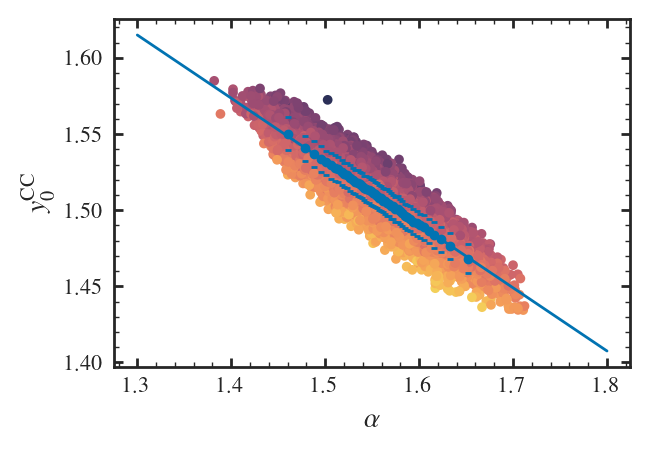

In [56]:
plt.scatter(m.samples.alpha, m.samples.y0_cc, c=m.samples.zeta_cc)

x = np.linspace(1.3, 1.8, 1000)
y = y0 + slope*(x - x0)

plt.plot(x, y)


plt.xlabel(r"$\alpha$")
plt.ylabel(r"$y_0^{\rm CC}$")

arya.medianplot(m.samples, x="alpha", y="y0_cc", binsize=1000, )

If total yield is conserved, then y0_cc + alpha * y_agb = y_tot
so the d y0 / d alpha = - y_agb

In [74]:
y_agb = -slope
alpha_0 = x0
y0 = y0
y0 + alpha_0 * y_agb, y_agb

(np.float64(2.154648815623643), np.float64(0.41506309476470776))

In [75]:
yagb_props["fruity"]["y0"]

0.000311

Similarly, is the AGB trend is well-described by a linear trend, then 

$$
(y_{0, cc} + \zeta  (Z-Z0) / Z0) + \alpha * (y_a + \zeta * (Z-Z0)/Z0) = y_{0, tot} + \zeta_{tot} *(Z-Z0) / Z0
$$

The zeta terms seperate out as before, so the d zeta / d alpha = - zeta_agb

In [50]:
x0_z, y0_z, slope_z = fit_lin_trend(m, "alpha", "zeta_cc")
x0_z, y0_z, slope_z

(np.float64(1.5558242068794674),
 np.float64(0.7194320720878589),
 np.float64(0.06108743878719741))

In [51]:
to_log_slope(slope)

np.float64(-0.9557180946571912)

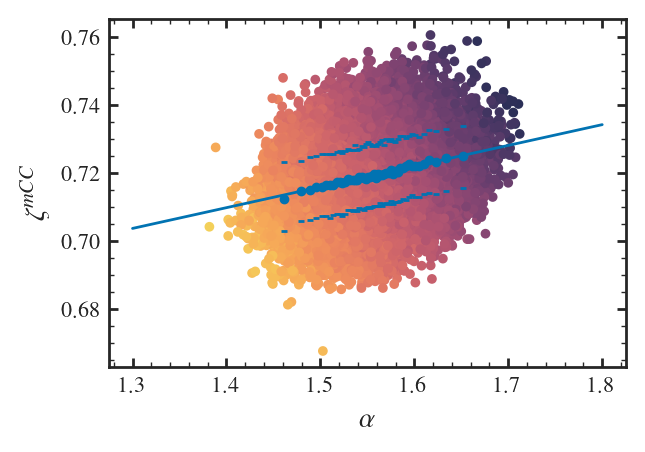

In [52]:
plt.scatter(m.samples.alpha, m.samples.zeta_cc, c=m.samples.y0_cc)

x = np.linspace(1.3, 1.8, 1000)
y = y0_z + slope_z*(x - x0_z)

plt.plot(x, y)

plt.xlabel(r"$\alpha$")
plt.ylabel("$\zeta^{\rm CC}$")

arya.medianplot(m.samples, x="alpha", y="zeta_cc", binsize=1000, )

In [53]:
to_log_slope(0.72)

1.6578612669557131

In [54]:
df = get_params("fruity_fz0.3");
print()
make_new_params(df, "fruity")


alpha
y0_cc   	1.080	-0.008	+0.009
zeta_cc 	0.789	-0.010	+0.009
alpha   	2.570	-0.000	+0.000

alpha_c_agb = 2.57
y0_c_cc = 1.87e-03
zeta_c_cc = 1.82e-03
f = 0.300


In [55]:
y0

np.float64(1.5088836054064043)

In [57]:
def make_f_agb_zeta(df, f_new, study="fruity"):
    y0_l = get_df_key(df, "y0_cc")
    slope_l = get_df_key(df, "zeta_cc")
    alpha = get_df_key(df, "alpha")
    y0_s = (y0_l + slope_l) * 1e-3
    
    ya = yagb_props[study]["y0"]
    ytot = ya * alpha + y0_s
    
    f_agb = ya * alpha / ytot
    print("f_agb_old", f_agb)

    alpha_new = f_new * ytot / ya

    y0_new = ytot - alpha_new * ya
    y0_2 = y0 + slope * (alpha_new - x0)
    zeta_new = y0_z + slope_z * (alpha_new - x0_z)
    
    f_new_new = ya * alpha_new / ytot

    print(f"y0 = {y0_new:0.3e}" )
    print(f"y0 = {y0_2:0.3e}" )
    print(f"zeta = {to_log_slope(zeta_new) * 1e-3:0.3e}" )
    print(f"alpha = {alpha_new:0.3f}" )

    print(f"f = {f_new_new:0.3f}" )
    


In [58]:
make_f_agb_zeta(df, 0.1)

f_agb_old 0.2995387609060838
y0 = 2.402e-03
y0 = 1.799e+00
zeta = 1.558e-03
alpha = 0.858
f = 0.100


In [59]:
make_f_agb_zeta(df, 0.305)

f_agb_old 0.2995387609060838
y0 = 1.854e-03
y0 = 1.068e+00
zeta = 1.806e-03
alpha = 2.617
f = 0.305


In [60]:
make_f_agb_zeta(df, 0.5)

f_agb_old 0.2995387609060838
y0 = 1.334e-03
y0 = 3.741e-01
zeta = 2.041e-03
alpha = 4.290
f = 0.500


In [65]:
def make_mass_shift_alpha(mf=0.5, alpha=2.71):
    ya_new = yagb_props[f"fruity_mf{mf}"]["y0"]
    ya_old = yagb_props[f"fruity"]["y0"]
    return alpha * ya_old / ya_new

In [66]:
yagb_props[f"fruity"]["y0"]

0.000311

In [67]:
make_mass_shift_alpha(0.5)

2.9781272084805654

In [68]:
make_mass_shift_alpha(0.7)

2.3411388888888887

In [69]:
make_mass_shift_alpha(1.5)

2.71

In [70]:
yagb_props["nugrid"]["y0"]

0.000925

In [71]:
vice.yields.agb.settings["c"]  = surp.agb_interpolator.interpolator("c", study="battino19")

surp.yields.calc_y(kind="agb")

0.0009248417861815101